In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from RobotSim373 import *

Version:  0.0.43


In [3]:
def build(robot):
    R=.5
    r=R/5
    
    x=2
    y=3
    angle=0
    disk_center=Disk(robot,x,y,radius=R,angle=angle,name='center')

    disks=[]
    for angle in range(0,360,30):
        disk=Disk(robot,
                          x+(R+1.1*r)*cos(radians(angle)),
                          y+(R+1.1*r)*sin(radians(angle)),
                 angle=angle,radius=r,
                 name='disk %d' % angle)
        disks.append(disk)

    connect(disk_center,disks,'weld')

    left=Box(robot,x=x-1,y=y,width=.1,height=3.5,name="left")
    right=Box(robot,x=x+1,y=y,width=.1,height=3.5,name="right")
    connect(disk_center,left,'weld')    
    connect(disk_center,right,'weld')    
    
    robot.disks=disks
    robot.angles=list(range(0,360,30))
    robot.distances=[-1]*len(disks)

In [4]:
def right(t,robot):
    for disk in robot.disks:
        disk.F=0
        
    robot['disk 0'].F=10
    return True

def up(t,robot):
    for disk in robot.disks:
        disk.F=0
        
    robot['disk 90'].F=10
    return True

def down(t,robot):
    for disk in robot.disks:
        disk.F=0
        
    robot['disk 270'].F=10
    return True

def left(t,robot):
    for disk in robot.disks:
        disk.F=0
        
    robot['disk 180'].F=10
    return True


In [5]:
def until_right_wall(t,robot):
    distance=robot['disk 0'].read_distance()
    
    if distance<2:
        return True
    
    
def until_top_wall(t,robot):
    distance=robot['disk 90'].read_distance()
    
    if distance<2:
        return True
    
def until_bottom_wall(t,robot):
    distance=robot['disk 270'].read_distance()
    
    if distance<2:
        return True    
    
def until_left_wall(t,robot):
    distance=robot['disk 180'].read_distance()
    
    if distance<2:
        return True        

In [6]:
def monitor(t,robot):
    robot.message=t

In [7]:
state_machine=StateMachine(
    (right,'until_right_wall'),
    (until_right_wall,"_end_simulation")
)




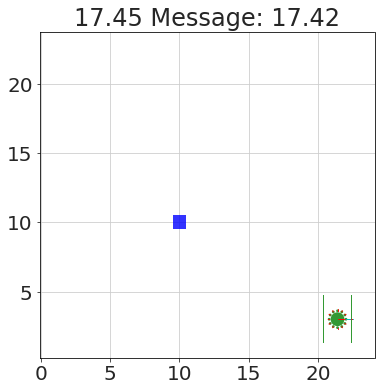

In [8]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

Box(env,x=10,y=10)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=30,
       dt_display=0.3,  # make this larger for a faster display
       )


Let's say I want to start robot in lower left, take this piece that is at 10,10 and move it to 15,10 and then return to the lower left.

- move to the right until aligned with the object (known location, or distance sensor) = move to the right until x=10
- move up until y=8
- move again to the right until x=15
- move down to the ground
- move back to the left wall



In [9]:
state_machine=StateMachine(
    ([right,until_right_wall],'up'),
    ([up,until_top_wall],'left'),
    ([left,until_left_wall],'_end_simulation'),
)




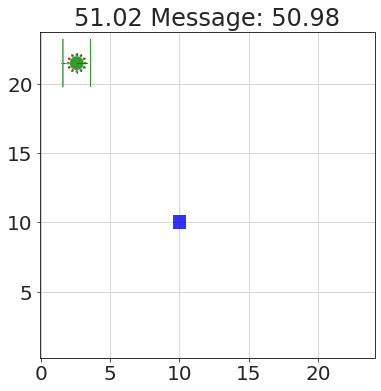

In [10]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

Box(env,x=10,y=10)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=100,
       dt_display=0.3,  # make this larger for a faster display
       )


In [11]:
def until_piece_up(t,robot):
    distance=robot['disk 90'].read_distance()
    
    if distance<10:
        return True    
    
def until_close_to_piece(t,robot):
    distance=robot['disk 90'].read_distance()
    
    if distance<0.1:
        return True        

In [12]:
state_machine=StateMachine(
    ([right,until_piece_up,wait(0.1)],'up'),
    ([up,until_close_to_piece],'left'),
    ([left,until_left_wall],'down'),
    ([down,until_bottom_wall],'_end_simulation'),
)




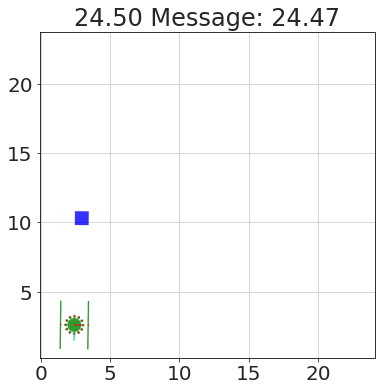

In [101]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(state_machine)
robot.controller.monitor=monitor

Box(env,x=10,y=10,density=0.001)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=100,
       dt_display=0.3,  # make this larger for a faster display
       )


## Counting

In [13]:
def count(t,robot):
    
    right(t,robot)
    distance=robot['disk 90'].read_distance()
    
    piece_up=distance<10
    
    if piece_up and not robot.seeing_piece:
        robot.count+=1
        robot.seeing_piece=True

    if not piece_up:
        robot.seeing_piece=False
        
    distance=robot['disk 0'].read_distance()
    if distance<2:
        return "down"
        
        
        
    


In [14]:
counting_state_machine=StateMachine(
    ([right,until_piece_up],'count'),
    (count,'down'),
    ([left,until_left_wall],'_end_simulation'),
    ([down,until_bottom_wall],'left'),
)



In [15]:
def monitor(t,robot):
    robot.message=t,robot.count,robot.controller.current_state

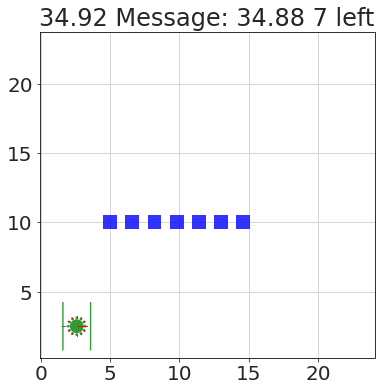

In [144]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(counting_state_machine)
robot.controller.monitor=monitor

robot.count=0
robot.seeing_piece=False


for i in range(randint(1,8)):
    Box(env,x=5+i*1.6,y=10,density=0.001)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=100,
       dt_display=0.3,  # make this larger for a faster display
       )


## Counting then taking a piece

In [16]:

take_one_piece_state_machine=StateMachine(
    ([right,until_piece_up,wait(0.1)],'up'),
    ([up,until_close_to_piece],'left'),
    ([left,until_left_wall],'down'),
    ([down,until_bottom_wall],'_end_simulation'),
)


counting_state_machine=StateMachine(
    ([right,until_piece_up],'count'),
    (count,'down'),
    ([left,until_left_wall],take_one_piece_state_machine),
    ([down,until_bottom_wall],'left'),
)


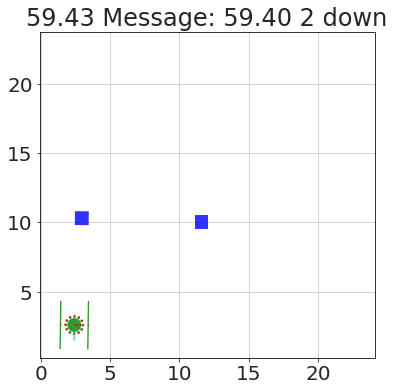

In [17]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(counting_state_machine)
robot.controller.monitor=monitor

robot.count=0
robot.seeing_piece=False


for i in range(randint(1,8)):
    Box(env,x=10+i*1.6,y=10,density=0.001)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=100,
       dt_display=0.3,  # make this larger for a faster display
       )


## taking a few..this has a bug, because there isn't a good place for the pieces

In [18]:
def turn_green(t,robot):
    robot.color='g'
    return True

def turn_red(t,robot):
    robot.color='r'
    return True

def turn_purple(t,robot):
    robot.color='purple'
    return True

def set_move(t,robot):
    count=robot.count
    robot.move=(count-1)%4
    if robot.move==0:
        robot.move=1
        
    return True

def until_turn_over(t,robot):
    robot.move-=1
    robot.color=f"#{randint(0x1000000):06x}"

    if robot.move==0:
        return "_end_simulation"
    else:
        return "right"

In [19]:

take_pieces_state_machine=StateMachine(
    (turn_purple,"right"),
    ([right,until_piece_up,wait(0.1)],'up'),
    ([up,until_close_to_piece],'left'),
    ([left,until_left_wall],'down'),
    ([down,until_bottom_wall],'until_turn_over'),
     (until_turn_over,'turn_green'),
    (turn_green,"_end_simulation"),
)


counting_state_machine=StateMachine(
    (turn_green,"right"),
    ([right,until_piece_up],'count'),
    (count,'down'),
    ([down,until_bottom_wall],'left'),
    ([left,until_left_wall],"set_move"),
    (set_move,take_pieces_state_machine),
)

In [20]:
def monitor(t,robot):
    robot.message=t,robot.count,robot.move,robot.controller.current_state

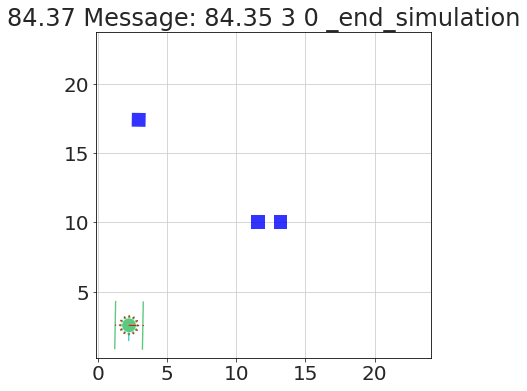

In [22]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(counting_state_machine)
robot.controller.monitor=monitor

robot.count=0
robot.seeing_piece=False
robot.move=None


for i in range(randint(1,8)):
    Box(env,x=10+i*1.6,y=10,density=0.001)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=100,
       dt_display=1,  # make this larger for a faster display
       )


## taking a few -- pushing them up rather than to the left

In [23]:

    
def up_some_more(t,robot):
    up(t,robot)
    
    distance=robot['disk 270'].read_distance()
    if distance>20:
        return True
        
    
    

In [24]:

take_pieces_state_machine=StateMachine(
    (turn_purple,"right"),
    ([right,until_piece_up,wait(0.1)],'up'),
    ([up,until_close_to_piece],'up_some_more'),
    (up_some_more,"down"),
    ([down,until_bottom_wall],'left'),  # swapped the order or left and down
    ([left,until_left_wall],'until_turn_over'),
     (until_turn_over,'_end_simulation'),
)


counting_state_machine=StateMachine(
    (turn_green,"right"),
    ([right,until_piece_up],'count'),
    (count,'down'),
    ([down,until_bottom_wall],'left'),
    ([left,until_left_wall],"set_move"),
    (set_move,take_pieces_state_machine),
)

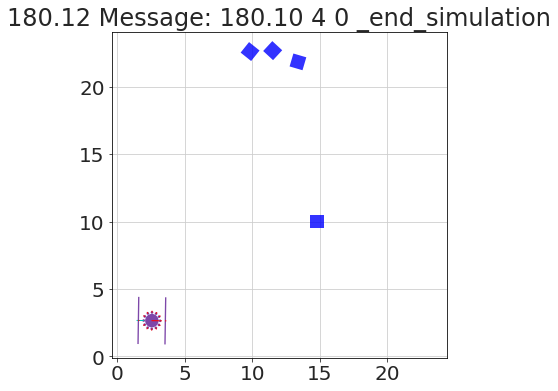

In [30]:
env=FrictionEnvironment(24,24)
robot=Robot(env)
build(robot)
robot.controller=Controller(counting_state_machine)
robot.controller.monitor=monitor

robot.count=0
robot.seeing_piece=False
robot.move=None


for i in range(randint(1,8)):
    Box(env,x=10+i*1.6,y=10,density=0.001)

run_sim(env,robot.controller, 
        figure_width=6,
       total_time=500,
       dt_display=1,  # make this larger for a faster display
       )
